In [106]:
%load_ext autoreload
%autoreload 2

import boto3
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import sys

from run_utils import compute_across_trials_s3, plot_ratings_mses_s3
from run_utils import ModelTuner
from run_utils import get_env_dataset

sys.path.append('../') 
from reclab.environments import Topics, LatentFactorBehavior 
from reclab.recommenders import Cfnade
from reclab.recommenders import EASE
from reclab.recommenders import LibFM
from reclab.recommenders import KNNRecommender
from reclab.recommenders import TopPop
from reclab.recommenders import Autorec
from reclab.recommenders import Llorma
from reclab.recommenders import PerfectRec
from reclab.recommenders import RandomRec
from env_defaults import TOPICS_STATIC, TOPICS_DYNAMIC, LATENT_STATIC, LATENT_DYNAMIC, get_len_trial, TOPICS_DYNAMIC_SMALL, ML_100K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
matplotlib.rcParams['text.usetex'] = False
sns.set(style="ticks")
plt.rc('font', family='serif')
plt.rc('font', serif='Times New Roman')

bigfont = 18
medfont = 14
smallfont = 12
sns.set_style('ticks', {'font.family':'serif', 'font.serif':'Times New Roman'})

sns.set_palette("muted")

In [108]:
bucket_name = 'recsys-eval'
bucket = boto3.resource('s3').Bucket(bucket_name)
data_dir = 'master'

In [95]:
def mean(ratings, predictions):
    return ratings[0].mean()

In [296]:
n = dict()
n['num_init_ratings'] = 130000
n

{'rating_frequency': 0.2,
 'num_init_ratings': 130000,
 'noise': 0.5,
 'topic_change': 0,
 'memory_length': 0,
 'boredom_threshold': 0,
 'boredom_penalty': 0}

In [109]:
env = Topics(**TOPICS_STATIC['params'], **TOPICS_STATIC['optional_params'])
recommenders = [
    (Autorec, dict(
        base_lr=0.001,
        batch_size=1000,
        dropout=0.05,
        grad_clip=False,
        hidden_neuron=500,
        lambda_value=1,
        num_items=1700,
        num_users=1000,
        optimizer_method='RMSProp',
        random_seed=0,
        train_epoch=500
    )),
    (Cfnade, dict(
        batch_size=64,
        hidden_dim=500,
        learning_rate=0.001,
        normalized_layer=False,
        num_items=1700,
        num_users=1000,
        rating_bucket=5,
        train_epoch=30
    )),
    (EASE, dict(
        binarize=False,
        lam=5000
    )),
    (KNNRecommender, dict(
        neighborhood_size=250,
        shrinkage=0,
        user_based=False
    )),
    (LibFM, dict(
        max_num_items=1700,
        max_num_users=1000,
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        method='mcmc',
        num_iter=200,
        num_two_way_factors=20,
        init_stdev=1.0,
    )),
    (LibFM, dict(
        max_num_items=1700,
        max_num_users=1000,
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        method='sgd',
        num_iter=200,
        num_two_way_factors=20,
        init_stdev=1.0,
        learning_rate=0.01,
        reg=0.07
    )),
    (Llorma, dict(
        batch_size=1000,
        lambda_val=0.0001,
        learning_rate=0.02,
        max_item=1700,
        max_user=1000,
        n_anchor=10,
        pre_lambda_val=0.01,
        pre_learning_rate=0.0003,
        pre_rank=10,
        pre_train_steps=70,
        rank=20,
        result_path='static_res',
        train_steps=50,
        use_cache=False,
        kernel_fun=None
    )),
    (PerfectRec, dict(
        dense_rating_function=lambda: env.dense_ratings
    )),
    (RandomRec, dict(
        
    )),
    (TopPop, dict(
        
    )),
    (KNNRecommender, dict(
        neighborhood_size=250,
        shrinkage=0,
        user_based=True
    )),
]

In [110]:
mses = []
for recommender, params in recommenders:
    print(recommender)
    tuner = ModelTuner(get_env_dataset(env), params, recommender)
    recommender_mses = tuner.evaluate({})
    mses.append(recommender_mses)
mses = np.array(mses)
rmse = np.sqrt(mses)
rmse_std = np.std(rmse, axis=1) / np.sqrt(4)
rmse = rmse.mean(axis=1)
mses = mses.mean(axis=1)

<class 'reclab.recommenders.autorec.autorec.Autorec'>
Evaluating: {}
Fold 1/5, mse=1.9213182269471671, rmse=1.3861162386131862
Fold 2/5, mse=1.9031439013933042, rmse=1.3795448167396753
Fold 3/5, mse=1.8596135110296717, rmse=1.3636764686059784
Fold 4/5, mse=1.8913645695035852, rmse=1.375268908069831
Fold 5/5, mse=1.9104731769062369, rmse=1.3821986749039505
Average Metric: 1.897182677155993
<class 'reclab.recommenders.cfnade.cfnade.Cfnade'>


/home/ec2-user/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output predicted_ratings missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to predicted_ratings.
  'be expecting any data to be passed to {0}.'.format(name))


Evaluating: {}
Fold 1/5, Epoch 1/30
26/26 [==============================] - 2s 59ms/step - loss: 140.1610 - nade_loss_loss: 77.7541
Epoch 2/30
26/26 [==============================] - 1s 46ms/step - loss: 113.1036 - nade_loss_loss: 74.0422
Epoch 3/30
26/26 [==============================] - 1s 46ms/step - loss: 100.2830 - nade_loss_loss: 73.0692
Epoch 4/30
26/26 [==============================] - 1s 46ms/step - loss: 92.1772 - nade_loss_loss: 72.2870
Epoch 5/30
26/26 [==============================] - 1s 46ms/step - loss: 87.2582 - nade_loss_loss: 71.9900
Epoch 6/30
26/26 [==============================] - 1s 45ms/step - loss: 84.3821 - nade_loss_loss: 72.1412
Epoch 7/30
26/26 [==============================] - 1s 45ms/step - loss: 81.8198 - nade_loss_loss: 71.6870
Epoch 8/30
26/26 [==============================] - 1s 46ms/step - loss: 80.3070 - nade_loss_loss: 71.5808
Epoch 9/30
26/26 [==============================] - 1s 45ms/step - loss: 79.1554 - nade_loss_loss: 71.3131
Epoch 10/

26/26 [==============================] - 1s 45ms/step - loss: 77.5764 - nade_loss_loss: 69.7133
Epoch 16/30
26/26 [==============================] - 1s 45ms/step - loss: 77.5504 - nade_loss_loss: 69.7326
Epoch 17/30
26/26 [==============================] - 1s 45ms/step - loss: 77.5127 - nade_loss_loss: 69.7370
Epoch 18/30
26/26 [==============================] - 1s 46ms/step - loss: 77.1852 - nade_loss_loss: 69.4577
Epoch 19/30
26/26 [==============================] - 1s 45ms/step - loss: 77.1073 - nade_loss_loss: 69.3311
Epoch 20/30
26/26 [==============================] - 1s 45ms/step - loss: 76.7995 - nade_loss_loss: 68.9724
Epoch 21/30
26/26 [==============================] - 1s 45ms/step - loss: 76.7904 - nade_loss_loss: 68.8308
Epoch 22/30
26/26 [==============================] - 1s 45ms/step - loss: 76.7020 - nade_loss_loss: 68.5992
Epoch 23/30
26/26 [==============================] - 1s 45ms/step - loss: 76.9843 - nade_loss_loss: 68.6721
Epoch 24/30
26/26 [=====================

26/26 [==============================] - 1s 45ms/step - loss: 76.4110 - nade_loss_loss: 67.9947
mse=1.6199620397826378, rmse=1.272777293866699
Average Metric: 1.6124970591076326
<class 'reclab.recommenders.sparse.EASE'>
Evaluating: {}
Fold 1/5, mse=10.280933471258235, rmse=3.2063894759149636
Fold 2/5, mse=10.113779591733914, rmse=3.1802169095415356
Fold 3/5, mse=10.105726257906221, rmse=3.1789504962968866
Fold 4/5, mse=10.17469567440458, rmse=3.189779878675734
Fold 5/5, mse=10.16767370631834, rmse=3.1886789907920083
Average Metric: 10.16856174032426
<class 'reclab.recommenders.knn_recommender.KNNRecommender'>
Evaluating: {}
Fold 1/5, mse=1.9012520616351627, rmse=1.378858970901362
Fold 2/5, mse=1.9421811692335789, rmse=1.393621601882512
Fold 3/5, mse=1.9134458187585761, rmse=1.3832735878193352
Fold 4/5, mse=1.9209003158334155, rmse=1.3859654814725422
Fold 5/5, mse=1.935641930613931, rmse=1.391273492385279
Average Metric: 1.922684259214933
<class 'reclab.recommenders.libfm.LibFM'>
Evalua

In [112]:
ndcgs = []
for recommender, params in recommenders:
    print(recommender)
    tuner = ModelTuner(get_env_dataset(env), params, recommender, use_mse=False)
    recommender_dcgs = tuner.evaluate({})
    ndcgs.append(recommender_dcgs)
ndcgs = np.array(ndcgs)
ndcgs_std = ndcgs.std(axis=1)
ndcgs = ndcgs.mean(axis=1)

<class 'reclab.recommenders.autorec.autorec.Autorec'>
Evaluating: {}
Fold 1/5, dcg=20.106423255640937, ndcg=0.8475090422689586
Fold 2/5, dcg=19.931924769032367, ndcg=0.8440030051610365
Fold 3/5, dcg=20.15826529674416, ndcg=0.8475177225833603
Fold 4/5, dcg=19.87164249213886, ndcg=0.84167124792707
Fold 5/5, dcg=19.987216623304327, ndcg=0.8440636120393863
Average Metric: 0.8449529259959624
<class 'reclab.recommenders.cfnade.cfnade.Cfnade'>


/home/ec2-user/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output predicted_ratings missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to predicted_ratings.
  'be expecting any data to be passed to {0}.'.format(name))


Evaluating: {}
Fold 1/5, Epoch 1/30
26/26 [==============================] - 2s 61ms/step - loss: 140.1610 - nade_loss_loss: 77.7541
Epoch 2/30
26/26 [==============================] - 1s 46ms/step - loss: 113.1021 - nade_loss_loss: 74.0422
Epoch 3/30
26/26 [==============================] - 1s 48ms/step - loss: 100.2796 - nade_loss_loss: 73.0690
Epoch 4/30
26/26 [==============================] - 1s 47ms/step - loss: 92.1750 - nade_loss_loss: 72.2868
Epoch 5/30
26/26 [==============================] - 1s 46ms/step - loss: 87.2556 - nade_loss_loss: 71.9904
Epoch 6/30
26/26 [==============================] - 1s 46ms/step - loss: 84.3791 - nade_loss_loss: 72.1412
Epoch 7/30
26/26 [==============================] - 1s 46ms/step - loss: 81.8178 - nade_loss_loss: 71.6868
Epoch 8/30
26/26 [==============================] - 1s 46ms/step - loss: 80.3055 - nade_loss_loss: 71.5804
Epoch 9/30
26/26 [==============================] - 1s 45ms/step - loss: 79.1544 - nade_loss_loss: 71.3127
Epoch 10/

26/26 [==============================] - 1s 45ms/step - loss: 77.5764 - nade_loss_loss: 69.7133
Epoch 16/30
26/26 [==============================] - 1s 45ms/step - loss: 77.5504 - nade_loss_loss: 69.7326
Epoch 17/30
26/26 [==============================] - 1s 45ms/step - loss: 77.5128 - nade_loss_loss: 69.7370
Epoch 18/30
26/26 [==============================] - 1s 45ms/step - loss: 77.1852 - nade_loss_loss: 69.4577
Epoch 19/30
26/26 [==============================] - 1s 46ms/step - loss: 77.1073 - nade_loss_loss: 69.3311
Epoch 20/30
26/26 [==============================] - 1s 46ms/step - loss: 76.7995 - nade_loss_loss: 68.9724
Epoch 21/30
26/26 [==============================] - 1s 46ms/step - loss: 76.7904 - nade_loss_loss: 68.8308
Epoch 22/30
26/26 [==============================] - 1s 46ms/step - loss: 76.7020 - nade_loss_loss: 68.5992
Epoch 23/30
26/26 [==============================] - 1s 46ms/step - loss: 76.9843 - nade_loss_loss: 68.6721
Epoch 24/30
26/26 [=====================

26/26 [==============================] - 1s 46ms/step - loss: 76.4110 - nade_loss_loss: 67.9947
dcg=21.442057001398897, ndcg=0.9039660891160184
Average Metric: 0.9019563380381456
<class 'reclab.recommenders.sparse.EASE'>
Evaluating: {}
Fold 1/5, dcg=20.09515501261453, ndcg=0.8429765180730583
Fold 2/5, dcg=19.800438502622352, ndcg=0.8393770612963545
Fold 3/5, dcg=19.968756242973374, ndcg=0.8443609086330733
Fold 4/5, dcg=19.843642915821093, ndcg=0.8400457830679297
Fold 5/5, dcg=19.86535425027181, ndcg=0.8388653933760166
Average Metric: 0.8411251328892865
<class 'reclab.recommenders.knn_recommender.KNNRecommender'>
Evaluating: {}
Fold 1/5, dcg=20.087706660251413, ndcg=0.8495497452540036
Fold 2/5, dcg=20.138535029384798, ndcg=0.8497359963766393
Fold 3/5, dcg=20.165147171163117, ndcg=0.8502965656524453
Fold 4/5, dcg=20.1716212252841, ndcg=0.8504481136390455
Fold 5/5, dcg=20.102750958739584, ndcg=0.8485774264809113
Average Metric: 0.8497215694806088
<class 'reclab.recommenders.libfm.LibFM'>


In [127]:
env_name = 'topics_static'
rec_names = ['Autorec', 'CFNade', 'EASE', 'ItemKnn', 'LibFM (MCMC)', 'LibFM (SGD)',
             'Llorma', 'PerfectRec', 'RandomRec', 'TopPop', 'UserKnn']
plot_names = ['AutoRec', 'CF-NADE', 'EASE', 'ItemKnn', 'Bayes MF', 'SGD MF',
              'LLORMA', 'Oracle', 'Random', 'TopPop', 'UserKnn']
trials = [i for i in range(10)]
means = []
stds = []
for rec_name in rec_names:
    rec_means = compute_across_trials_s3(bucket,
                                         data_dir,
                                         env_name,
                                         [rec_name],
                                         trials,
                                         mean,
                                         load_dense=False)
    stds.append(np.std(rec_means) / np.sqrt(len(trials) - 1))
    means.append(np.mean(rec_means))

In [128]:

print(np.corrcoef(means, ndcgs))
print(np.corrcoef(means, rmse))

[[1.         0.77435744]
 [0.77435744 1.        ]]
[[ 1.         -0.71555444]
 [-0.71555444  1.        ]]


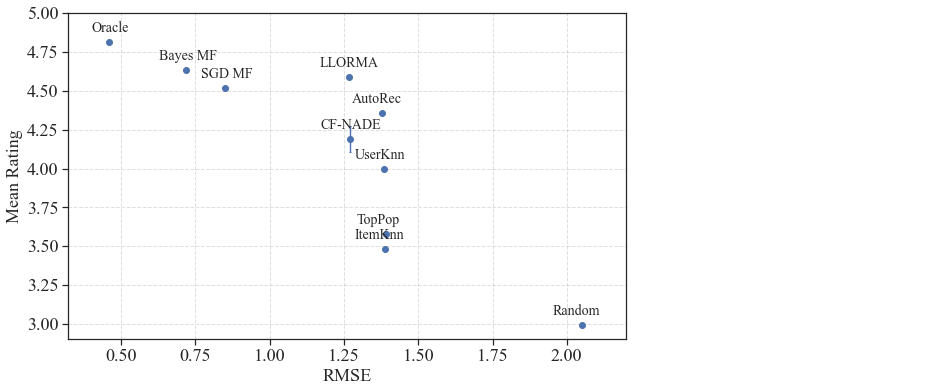

In [154]:
plt.figure(figsize=(10,6))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.errorbar(rmse, means, xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("RMSE", fontsize=bigfont)
plt.ylabel("Mean Rating", fontsize=bigfont)
plt.xlim(right=2.2)
plt.ylim(top=5.0)
for i, rec_name in enumerate(plot_names):
    if rec_name == 'Oracle':
        plt.annotate(rec_name, (rmse[i] - 0.06, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'SGD MF':
        plt.annotate(rec_name, (rmse[i] - 0.08, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'Bayes MF':
        plt.annotate(rec_name, (rmse[i] - 0.09, means[i] + 0.065), fontsize=medfont)
    else:
        plt.annotate(rec_name, (rmse[i] - 0.1, means[i] + 0.065), fontsize=medfont)

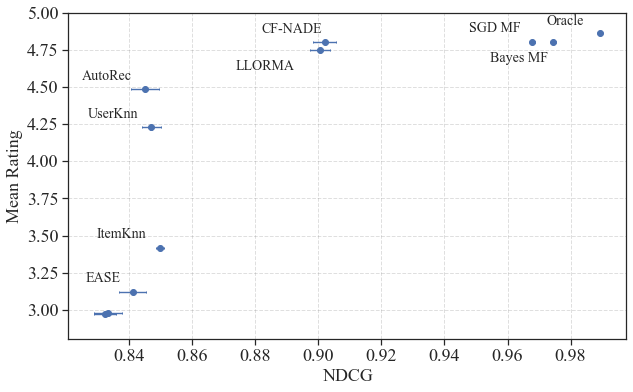

In [130]:
plt.figure(figsize=(10,6))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.errorbar(ndcgs, means, xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("NDCG", fontsize=bigfont)
plt.ylabel("Mean Rating", fontsize=bigfont)
plt.ylim(bottom=2.8, top=5.0)
for i, rec_name in enumerate(plot_names):
        if rec_name == 'EASE':
            plt.annotate(rec_name, (ndcgs[i] - 0.015, means[i] + 0.067), fontsize=medfont)
        elif rec_name == 'LLORMA':
            plt.annotate(rec_name, (ndcgs[i] - 0.027, means[i] - 0.135), fontsize=medfont)
        elif rec_name == 'Oracle':
            plt.annotate(rec_name, (ndcgs[i] - 0.017, means[i] + 0.055), fontsize=medfont)
        elif rec_name == 'Bayes MF':
            plt.annotate(rec_name, (ndcgs[i] - 0.02, means[i] - 0.135), fontsize=medfont)
        elif rec_name == 'TopPop':
            plt.annotate(rec_name, (ndcgs[i] - 0.02, means[i] - 0.135), fontsize=medfont)
        else:
            plt.annotate(rec_name, (ndcgs[i] - 0.02, means[i] + 0.065), fontsize=medfont)
plt.savefig('topics-static.pdf')

In [132]:
env_name = 'topics_dynamic'
rec_names = ['Autorec', 'CFNade', 'EASE', 'ItemKnn', 'LibFM (MCMC)', 'LibFM (SGD)',
             'Llorma', 'PerfectRec', 'RandomRec', 'TopPop', 'UserKnn']

trials = [i for i in range(10)]
means = []
stds = []
for rec_name in rec_names:
    rec_means = compute_across_trials_s3(bucket,
                                         data_dir,
                                         env_name,
                                         [rec_name],
                                         trials,
                                         mean,
                                         load_dense=False)
    stds.append(np.std(rec_means) / np.sqrt(len(trials) - 1))
    means.append(np.mean(rec_means))
    print(rec_means)

[4.366039762485473, 4.357066457996532, 4.351554748822432, 4.3515784753216025, 4.364997819895256, 4.357067506227463, 4.36461453340384, 4.350006820623721, 4.3519659212411215, 4.359401615618598]
[4.429624239717778, 4.418055009552435, 4.194398823341624, 4.1736535545218985, 4.15905129238224, 4.143986218660556, 4.153728882218983, 4.091741598783283, 4.071001071989146, 4.0736421773289235]
[3.1991494877547315, 3.183509062175625, 3.2095795249823933, 3.29105240917672, 3.183181528764373, 3.260500268634511, 3.1850345693719744, 3.193399006458102, 3.1912671679755427, 3.207569109430939]
[3.4669199038001746, 3.4941304205701083, 3.480395785533915, 3.477351135975055, 3.481520259153298, 3.4731783074334004, 3.5063473619457683, 3.4739222949244577, 3.482390387534795, 3.4855941221030187]
[4.632153100399585, 4.631565631483654, 4.62889961256519, 4.633783130962251, 4.631838518031459, 4.629960497614065, 4.6301594883559725, 4.62881646208072, 4.631498352862829, 4.632144057593799]
[4.523099413642537, 4.5189657539499

In [133]:
print(np.corrcoef(means, ndcgs))
print(np.corrcoef(means, rmse))

[[1.         0.80254557]
 [0.80254557 1.        ]]
[[ 1.         -0.80132506]
 [-0.80132506  1.        ]]


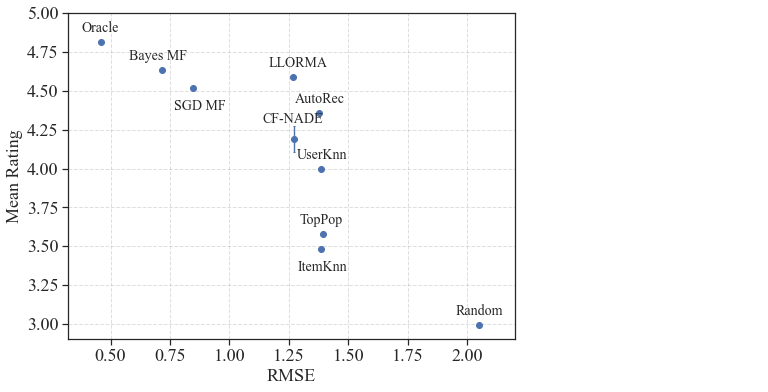

In [134]:
plt.figure(figsize=(8,6))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.errorbar(rmse, means, xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("RMSE", fontsize=bigfont)
plt.ylabel("Mean Rating", fontsize=bigfont)
plt.xlim(right=2.2)
plt.ylim(top=5.0)
for i, rec_name in enumerate(plot_names):
    if rec_name == 'Oracle':
        plt.annotate(rec_name, (rmse[i] - 0.08, means[i] + 0.06), fontsize=medfont)
    elif rec_name == 'SGD MF':
        plt.annotate(rec_name, (rmse[i] - 0.08, means[i] - 0.14), fontsize=medfont)
    elif rec_name == 'ItemKnn':
        plt.annotate(rec_name, (rmse[i] - 0.1, means[i] - 0.14), fontsize=medfont)
    elif rec_name == 'Bayes MF':
        plt.annotate(rec_name, (rmse[i] - 0.14, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'CF-NADE':
        plt.annotate(rec_name, (rmse[i] - 0.13, means[i] + 0.1), fontsize=medfont)
    else:
        plt.annotate(rec_name, (rmse[i] - 0.1, means[i] + 0.065), fontsize=medfont)
plt.savefig('topics-dynamic-rmse.pdf')

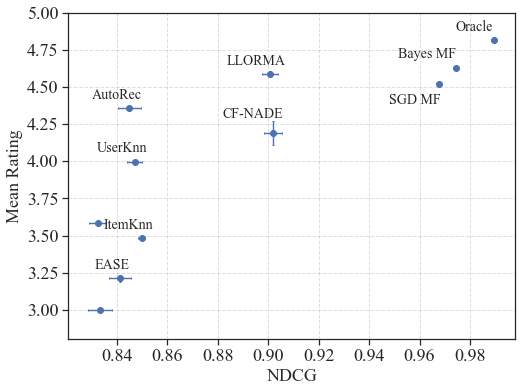

In [135]:
plt.figure(figsize=(8,6))
plt.xticks(fontsize=bigfont)
plt.yticks(fontsize=bigfont)
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.errorbar(ndcgs, means, xerr=ndcgs_std * 2, yerr=np.array(stds) * 2, linestyle='None', fmt='o', linewidth=1.4, capsize=1.4)
plt.xlabel("NDCG", fontsize=bigfont)
plt.ylabel("Mean Rating", fontsize=bigfont)
plt.ylim(bottom=2.8, top=5.0)
for i, rec_name in enumerate(plot_names):
    if rec_name == 'LLORMA':
        plt.annotate(rec_name, (ndcgs[i]- 0.017, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'CF-NADE':
        plt.annotate(rec_name, (ndcgs[i] - 0.02, means[i] + 0.1), fontsize=medfont)
    elif rec_name == 'LibFM (SGD)':
        plt.annotate(rec_name, (ndcgs[i] - 0.04, means[i] - 0.13), fontsize=medfont)
    elif rec_name == 'LibFM (MCMC)':
        plt.annotate(rec_name, (ndcgs[i] - 0.04, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'EASE':
        plt.annotate(rec_name, (ndcgs[i] - 0.01, means[i] + 0.065), fontsize=medfont)
    elif rec_name == 'SGD MF':
        plt.annotate(rec_name, (ndcgs[i] - 0.02, means[i] - 0.13), fontsize=medfont)
    elif rec_name == 'Bayes MF':
        plt.annotate(rec_name, (ndcgs[i] - 0.023, means[i] + 0.065), fontsize=medfont)
    else:
        plt.annotate(rec_name, (ndcgs[i] - 0.015, means[i] + 0.065), fontsize=medfont)
plt.savefig('main-plot.pdf')

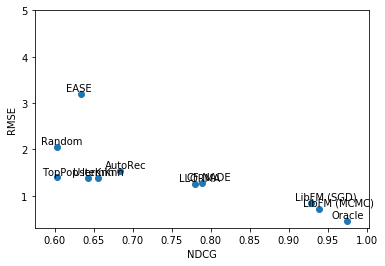

In [120]:
plt.scatter(ndcgs, mses)
plt.xlabel("NDCG")
plt.ylabel("RMSE")
plt.ylim(top=5.0)
for i, rec_name in enumerate(names):
        plt.annotate(rec_name, (ndcgs[i] - 0.02, mses[i] + 0.06))

In [62]:
env = LatentFactorBehavior(**LATENT_STATIC['params'], **LATENT_STATIC['optional_params'])
recommenders = [
    (Cfnade, dict(
        batch_size=128,
        hidden_dim=500,
        learning_rate=0.001,
        normalized_layer=False,
        num_items=1682,
        num_users=943,
        rating_bucket=5,
        train_epoch=30
    )),
    (EASE, dict(
        binarize=False,
        lam=5889
    )),
    (LibFM, dict(
        max_num_items=1682,
        max_num_users=943,
        num_user_features=0,
        num_item_features=0,
        num_rating_features=0,
        method='mcmc',
        num_iter=200,
        num_two_way_factors=20,
        init_stdev=1.0,
    )),
    (PerfectRec, dict(
        dense_rating_function=lambda: env.dense_ratings
    )),
    (RandomRec, dict(
        
    )),
    (TopPop, dict(
        
    )),
    (KNNRecommender, dict(
        neighborhood_size=250,
        shrinkage=0,
        user_based=True
    )),
]

In [63]:
mses = []
for recommender, params in recommenders:
    print(recommender)
    tuner = ModelTuner(get_env_dataset(env), params, recommender)
    recommender_mses = tuner.evaluate({})
    mses.append(np.mean(recommender_mses))

<class 'reclab.recommenders.cfnade.cfnade.Cfnade'>


/home/ec2-user/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output predicted_ratings missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to predicted_ratings.
  'be expecting any data to be passed to {0}.'.format(name))


Evaluating: {}
Fold 1/5, Epoch 1/30
13/13 [==============================] - 1s 96ms/step - loss: 143.9211 - nade_loss_loss: 78.0760
Epoch 2/30
13/13 [==============================] - 1s 70ms/step - loss: 114.3024 - nade_loss_loss: 68.4613
Epoch 3/30
13/13 [==============================] - 1s 70ms/step - loss: 98.4904 - nade_loss_loss: 64.8116
Epoch 4/30
13/13 [==============================] - 1s 70ms/step - loss: 89.5975 - nade_loss_loss: 63.8832
Epoch 5/30
13/13 [==============================] - 1s 70ms/step - loss: 82.5461 - nade_loss_loss: 62.5873
Epoch 6/30
13/13 [==============================] - 1s 70ms/step - loss: 78.5964 - nade_loss_loss: 62.6872
Epoch 7/30
13/13 [==============================] - 1s 70ms/step - loss: 75.7197 - nade_loss_loss: 62.6886
Epoch 8/30
13/13 [==============================] - 1s 72ms/step - loss: 73.2789 - nade_loss_loss: 62.3601
Epoch 9/30
13/13 [==============================] - 1s 71ms/step - loss: 71.6416 - nade_loss_loss: 62.2647
Epoch 10/3

13/13 [==============================] - 1s 69ms/step - loss: 71.6120 - nade_loss_loss: 64.6600
Epoch 16/30
13/13 [==============================] - 1s 69ms/step - loss: 67.3459 - nade_loss_loss: 60.6515
Epoch 17/30
13/13 [==============================] - 1s 69ms/step - loss: 66.8498 - nade_loss_loss: 60.3763
Epoch 18/30
13/13 [==============================] - 1s 69ms/step - loss: 66.9272 - nade_loss_loss: 60.5846
Epoch 19/30
13/13 [==============================] - 1s 69ms/step - loss: 66.4361 - nade_loss_loss: 60.2132
Epoch 20/30
13/13 [==============================] - 1s 70ms/step - loss: 66.4453 - nade_loss_loss: 60.3318
Epoch 21/30
13/13 [==============================] - 1s 69ms/step - loss: 66.2871 - nade_loss_loss: 60.3349
Epoch 22/30
13/13 [==============================] - 1s 69ms/step - loss: 65.6040 - nade_loss_loss: 59.7753
Epoch 23/30
13/13 [==============================] - 1s 69ms/step - loss: 65.9374 - nade_loss_loss: 60.1872
Epoch 24/30
13/13 [=====================

13/13 [==============================] - 1s 70ms/step - loss: 65.2211 - nade_loss_loss: 60.0327
mse=0.7815451003150563, rmse=0.8840503946693629
Average Metric: 0.7779210553780942
<class 'reclab.recommenders.sparse.EASE'>
Evaluating: {}
Fold 1/5, mse=9.250213584953244, rmse=3.0414163780964363
Fold 2/5, mse=9.27545119672773, rmse=3.045562541916966
Fold 3/5, mse=9.276731779558183, rmse=3.0457727721480117
Fold 4/5, mse=9.253909642509765, rmse=3.0420239385168824
Fold 5/5, mse=9.230152935430858, rmse=3.0381166757435203
Average Metric: 9.257291827835955
<class 'reclab.recommenders.libfm.LibFM'>
Evaluating: {}
Fold 1/5, mse=0.6806098171575335, rmse=0.8249907982259763
Fold 2/5, mse=0.6815374157978593, rmse=0.8255527940706514
Fold 3/5, mse=0.6863686078328799, rmse=0.8284736615203164
Fold 4/5, mse=0.6765104560698297, rmse=0.8225025568773813
Fold 5/5, mse=0.6766567366769707, rmse=0.8225914761757325
Average Metric: 0.6803366067070147
<class 'reclab.recommenders.baseline.PerfectRec'>
Evaluating: {}


In [64]:
ndcgs = []
for recommender, params in recommenders:
    print(recommender)
    tuner = ModelTuner(get_env_dataset(env), params, recommender, use_mse=False)
    recommender_dcgs = tuner.evaluate({})
    ndcgs.append(np.mean(recommender_dcgs))

<class 'reclab.recommenders.cfnade.cfnade.Cfnade'>


/home/ec2-user/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output predicted_ratings missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to predicted_ratings.
  'be expecting any data to be passed to {0}.'.format(name))


Evaluating: {}
Fold 1/5, Epoch 1/30
13/13 [==============================] - 1s 96ms/step - loss: 144.1326 - nade_loss_loss: 78.0548
Epoch 2/30
13/13 [==============================] - 1s 70ms/step - loss: 115.0355 - nade_loss_loss: 68.6927
Epoch 3/30
13/13 [==============================] - 1s 70ms/step - loss: 98.8480 - nade_loss_loss: 64.7707
Epoch 4/30
13/13 [==============================] - 1s 71ms/step - loss: 89.2919 - nade_loss_loss: 63.2595
Epoch 5/30
13/13 [==============================] - 1s 71ms/step - loss: 83.1558 - nade_loss_loss: 62.9633
Epoch 6/30
13/13 [==============================] - 1s 69ms/step - loss: 78.8786 - nade_loss_loss: 62.9293
Epoch 7/30
13/13 [==============================] - 1s 70ms/step - loss: 76.0231 - nade_loss_loss: 63.0341
Epoch 8/30
13/13 [==============================] - 1s 71ms/step - loss: 72.9165 - nade_loss_loss: 62.0257
Epoch 9/30
13/13 [==============================] - 1s 70ms/step - loss: 71.8162 - nade_loss_loss: 62.4790
Epoch 10/3

13/13 [==============================] - 1s 69ms/step - loss: 71.8317 - nade_loss_loss: 64.8849
Epoch 16/30
13/13 [==============================] - 1s 69ms/step - loss: 67.3343 - nade_loss_loss: 60.5822
Epoch 17/30
13/13 [==============================] - 1s 69ms/step - loss: 67.1291 - nade_loss_loss: 60.5391
Epoch 18/30
13/13 [==============================] - 1s 70ms/step - loss: 66.9141 - nade_loss_loss: 60.4951
Epoch 19/30
13/13 [==============================] - 1s 70ms/step - loss: 66.8211 - nade_loss_loss: 60.5472
Epoch 20/30
13/13 [==============================] - 1s 70ms/step - loss: 66.7334 - nade_loss_loss: 60.5992
Epoch 21/30
13/13 [==============================] - 1s 70ms/step - loss: 66.0982 - nade_loss_loss: 60.0590
Epoch 22/30
13/13 [==============================] - 1s 70ms/step - loss: 65.9354 - nade_loss_loss: 59.9941
Epoch 23/30
13/13 [==============================] - 1s 69ms/step - loss: 65.9638 - nade_loss_loss: 60.1897
Epoch 24/30
13/13 [=====================

13/13 [==============================] - 1s 69ms/step - loss: 65.0130 - nade_loss_loss: 59.7491
dcg=3.7263891379448673, ndcg=0.8025603877687587
Average Metric: 0.8050566585069243
<class 'reclab.recommenders.sparse.EASE'>
Evaluating: {}
Fold 1/5, dcg=3.319068533543733, ndcg=0.7129013097626651
Fold 2/5, dcg=3.2944132317765265, ndcg=0.7104084662725144
Fold 3/5, dcg=3.2646712511898235, ndcg=0.7017172013960433
Fold 4/5, dcg=3.3422240229575144, ndcg=0.7228674678077671
Fold 5/5, dcg=3.2701328447474873, ndcg=0.7051711708761443
Average Metric: 0.7106131232230268
<class 'reclab.recommenders.libfm.LibFM'>
Evaluating: {}
Fold 1/5, dcg=3.8228777071145923, ndcg=0.8230195801851061
Fold 2/5, dcg=3.809947244673431, ndcg=0.8182782559899024
Fold 3/5, dcg=3.798266180756229, ndcg=0.8197416557633458
Fold 4/5, dcg=3.780449472355531, ndcg=0.8117804486903955
Fold 5/5, dcg=3.8875576074999767, ndcg=0.8374659710695462
Average Metric: 0.8220571823396593
<class 'reclab.recommenders.baseline.PerfectRec'>
Evaluating:

In [65]:
env_name = 'latent_static'
rec_names = ['CFNade', 'EASE', 'LibFM (MCMC)',
             'PerfectRec', 'RandomRec', 'TopPop', 'UserKnn']

trials = [i for i in range(1)]
means = []
for rec_name in rec_names:
    print(rec_name)
    rec_means = compute_across_trials_s3(bucket,
                                         data_dir,
                                         env_name,
                                         [rec_name],
                                         trials,
                                         mean,
                                         load_dense=False)
    means.append(np.mean(rec_means))

CFNade
EASE
LibFM (MCMC)
PerfectRec
RandomRec
TopPop
UserKnn


7 7


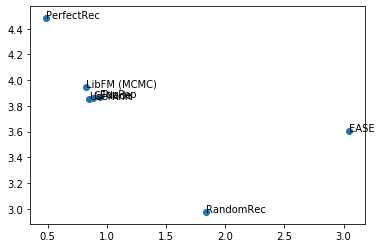

In [35]:
print(len(mses), len(means))
plt.scatter(mses, means)
for i, rec_name in enumerate(rec_names):
    plt.annotate(rec_name, (mses[i], means[i]))

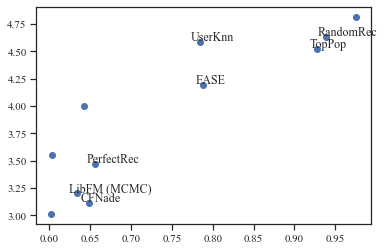

In [59]:
plt.scatter(ndcgs, means)
for i, rec_name in enumerate(rec_names):
    plt.annotate(rec_name, (ndcgs[i] - 0.01, means[i] + 0.01))

['Autorec', 'CFNade', 'LibFM (MCMC)', 'LibFM (SGD)', 'Llorma', 'TopPop']


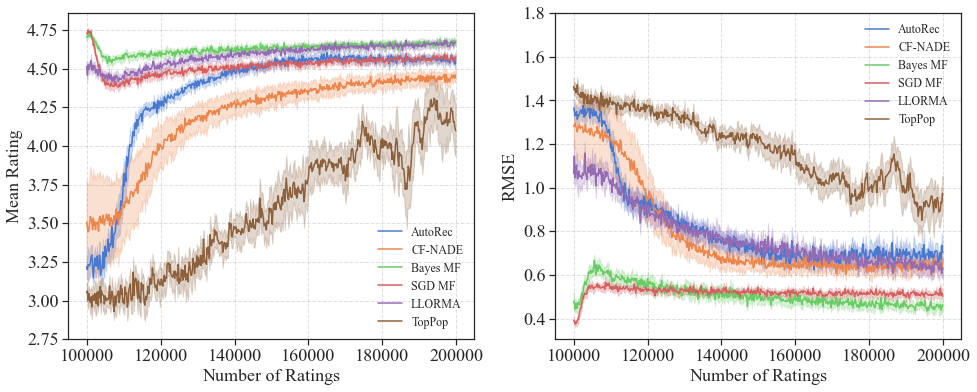

In [147]:
env_name = 'topics_dynamic'
labels = ['AutoRec', 'CF-NADE', 'Bayes MF', 'SGD MF', 'LLORMA', 'TopPop']
print(rec_names)
trials = [i for i in range(10)]
plot_ratings_mses_s3(rec_names,
                     labels,
                     500,
                     bucket_name,
                     data_dir,
                     env_name,
                     trials,
                     plot_dense=False,
                     num_users=1000,
                     rating_frequency=0.2,
                     num_init_ratings=100000)
plt.savefig('topics-dynamic-timeseries.pdf', bbox_inches='tight')

/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


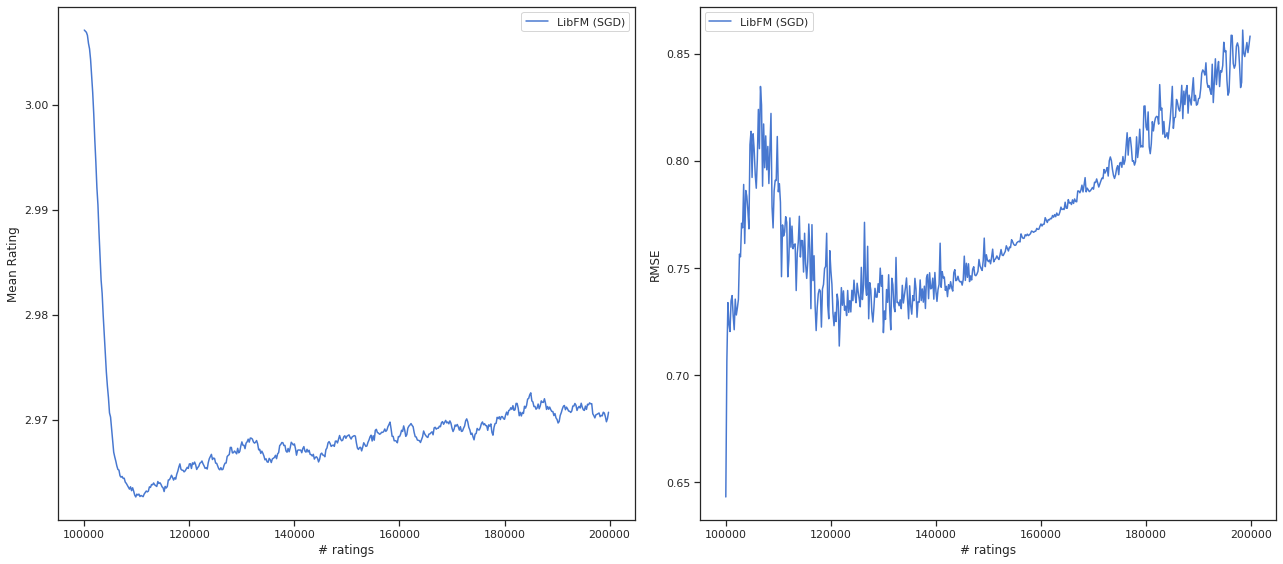

In [395]:
rec_names = ['CFNade', 'EASE', 'LibFM (MCMC)',
             'PerfectRec', 'RandomRec', 'TopPop', 'UserKnn']
plot_ratings_mses_s3(rec_names,
                     500,
                     bucket_name,
                     data_dir,
                     env_name,
                     list(range(1)),
                     plot_dense=True,
                     num_users=1000,
                     rating_frequency=0.2,
                     num_init_ratings=100000)

In [105]:
n = dict(TOPICS_STATIC['optional_params'])
n['num_init_ratings'] = 125000
env = Topics(**TOPICS_STATIC['params'], **n)
recommenders = [
    (Llorma, dict(
        batch_size=1000,
        lambda_val=0.0001,
        learning_rate=0.02,
        max_item=1700,
        max_user=1000,
        n_anchor=10,
        pre_lambda_val=0.01,
        pre_learning_rate=0.0003,
        pre_rank=10,
        pre_train_steps=70,
        rank=20,
        result_path='static_res',
        train_steps=50,
        use_cache=False,
        kernel_fun=None
    )),
]
for recommender, params in recommenders:
    print(recommender)
    tuner = ModelTuner(get_env_dataset(env), params, recommender, use_mse=False)
    recommender_dcgs = tuner.evaluate({})

<class 'reclab.recommenders.llorma.llorma.Llorma'>
Evaluating: {}
Fold 1/5, Pre-train step: 10, train_error:1.326422224868211
Pre-train step: 20, train_error:1.2871603053562815
Pre-train step: 30, train_error:1.2077244548352655
Pre-train step: 40, train_error:1.1220021274600624
Pre-train step: 50, train_error:1.0652472551050736
Pre-train step: 60, train_error:1.0124727647885492
Pre-train step: 70, train_error:0.9707840318853392
Train step:10, train error: 1.220514308749119, test error: 1.220514308749119
Train step:20, train error: 0.962720981024523, test error: 0.962720981024523
Train step:30, train error: 0.6410187999861175, test error: 0.6410187999861175
Train step:40, train error: 0.3894735281761837, test error: 0.3894735281761837
Train step:50, train error: 0.2526063086837266, test error: 0.2526063086837266
Low: 2.386, Mean: 2.977, High: 3.571
dcg=26.578477523290495, ndcg=0.9483317851023678
Fold 2/5, Pre-train step: 10, train_error:1.327915103574685
Pre-train step: 20, train_error: